<h1> Board Games and Video Games:</h1>
<h2>Understanding Language Differences</h2>
<h4> Dan Tadmor | Data Scientist</h4>

## Preface
  
This notebook goes through scraping the subreddits through creating models to predict the subreddits the posts came from.
  
You can view the presentation [here](https://youtu.be/02SRBiYCSG0).

## Importing the libraries

In [112]:
import requests
import json
import time
import pandas as pd
import regex as re
from nltk import PorterStemmer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

## Scraping the subreddits

In [2]:
def reddit_token_grabber(username, password, client_id, secret):
    
    # Get a token to use to scrape
    client_auth = requests.auth.HTTPBasicAuth(client_id, secret)
    post_data = {"grant_type": "password", "username": username, "password": password}
    headers = {"User-Agent": username + "Bot 0.1"}
    response = requests.post("https://www.reddit.com/api/v1/access_token", auth=client_auth, data=post_data, headers=headers)
    token = response.json()['access_token']
    return token

In [3]:
def subreddit_scraper(subreddit, username, password, client_id, secret, df, categories, sorter, n, t=''):

    
    # Set the index for the dataframe to save the results
    df_index = df.shape[0] + 1
    
    # Create an id column if the dataframe is empty
    if df.shape[0] == 0:
        df['id'] = ''
        
    # Prepate to grab the information from the appropriate json
    token = reddit_token_grabber(username, password, client_id, secret)
    headers = {"Authorization": "bearer " + token, "User-Agent": username + "Bot 0.1"}
    if sorter in ['controversial', 'top']:
        url = "http://oauth.reddit.com/r/{}/{}.json?t={}".format(subreddit, sorter, t)
    else:
        url = "http://oauth.reddit.com/r/{}/{}.json".format(subreddit, sorter)
    
    # Scrape until while loop is done
    for counter in range(n):
        
        # Get a bunch of subreddit posts and store them as data
        result = requests.get(url, headers=headers)
        data = result.json()['data']
        
        # For each entry in the json file, find the features we want and store it into a dataframe
        for i in range(len(data['children'])):
            if data['children'][i]['data']['id'] in df['id'].unique():
                pass
            else:
                for category in categories:
                    df.loc[df_index, category] = data['children'][i]['data'][category]
        
                # Also, get the main comments from the subreddit post
                if data['children'][i]['data']['num_comments'] > 0:
                    comments_url = 'http://oauth.reddit.com{}.json'.format(data['children'][i]['data']['permalink'])
                    comments_result = requests.get(comments_url, headers=headers)
                    comments_data = comments_result.json()[1]['data']['children']
                    comments = ''
                    for j in range(len(comments_data)):
                        try:
                            comments += comments_data[j]['data']['body']
                        except:
                            pass
                    df.loc[df_index, 'comments'] = comments
                else:
                    df.loc[df_index, 'comments'] = ''

                df_index += 1
        
        # Make updates and get ready to scrape again
        if result.headers['X-Ratelimit-Remaining'] == 0:
            print("Need to wait: {} seconds".format(result.headers(['X-Ratelimit-Reset'])))
            time.sleep(result.headers['X-Ratelimit-Reset'])
        after = data['after']
        if after == None:
            break
        if sorter in ['controversial', 'top']:
            url = "http://oauth.reddit.com/r/{}/{}.json?t={}&after={}".format(subreddit, sorter, t, after)
        else:
            url = "http://oauth.reddit.com/r/{}/{}.json?after={}".format(subreddit, sorter, after)
        
        # Keep the user updated on the progress
        if (counter + 1) % 10 == 0:
            print(counter + 1, 'scrapes')

        
    return

In [4]:
def subreddit_multi_scraper(subreddit, username, password, client_id, secret, df, categories, sort_list):

    # Cycle through each sorting method and scrape the subreddit with that sort
    for sorter in sort_list:
        if sorter in ['controversial', 'top']:
            for t in ['week', 'month', 'year', 'all']:
                subreddit_scraper(subreddit=subreddit, username=username, password=password, client_id=client_id, 
                                  secret=secret, df=df, categories=categories, sorter=sorter, n=1000, t=t)
                print("Completed scrape", sorter, t)
        else:
            subreddit_scraper(subreddit=subreddit, username=username, password=password, client_id=client_id, 
                              secret=secret, df=df, categories=categories, sorter=sorter, n=1000)
            print("Completed scrape", sorter)
    
    return

In [54]:
# Preparing to scrape
board_game_df = pd.DataFrame()
video_game_df = pd.DataFrame()
categories = ['ups', 'downs', 'likes', 'num_reports', 'selftext', 'selftext_html', 'gilded', 'distinguished',
              'over_18', 'num_comments', 'locked', 'score', 'title', 'stickied', 'id']
sort_list = ['new', 'hot', 'top']

In [315]:
# Creating the boardgame dataframe
subreddit_multi_scraper(subreddit='boardgames', username=username, password=password, client_id=client_id,
                        secret=secret, df=board_game_df, categories=categories, sort_list=sort_list)

10 scrapes
20 scrapes
30 scrapes
Completed scrape new
10 scrapes
20 scrapes
30 scrapes
Completed scrape hot
10 scrapes
Completed scrape top week
10 scrapes
20 scrapes
30 scrapes
40 scrapes
Completed scrape top month
10 scrapes
20 scrapes
30 scrapes
40 scrapes
Completed scrape top year
10 scrapes
20 scrapes
30 scrapes
Completed scrape top all


In [55]:
# Creating the video game dataframe
subreddit_multi_scraper(subreddit='videogames', username=username, password=password, client_id=client_id,
                        secret=secret, df=video_game_df, categories=categories, sort_list=sort_list)

10 scrapes
20 scrapes
30 scrapes
Completed scrape new
10 scrapes
20 scrapes
30 scrapes
Completed scrape hot
10 scrapes
Completed scrape top week
10 scrapes
20 scrapes
30 scrapes
Completed scrape top month
10 scrapes
20 scrapes
30 scrapes
40 scrapes
Completed scrape top year
10 scrapes
20 scrapes
30 scrapes
40 scrapes
Completed scrape top all


In [57]:
# Export to csv
# board_game_df.to_csv('./data/board_games', index=False)
# video_game_df.to_csv('./data/video_games', index=False)

In [64]:
board_game_df = pd.read_csv('./data/board_games')
video_game_df = pd.read_csv('./data/video_games')

## Preparing the text to be ready for NLP methods

In [65]:
def  text_prep(text):

    # Remove the annoying '\n's
    text = re.sub("[^a-zA-Z]", " ", text)
    # Making all the letters to lower case
    words = text.lower().split()
    # Use a stemmer to find the word stems
    stem = PorterStemmer()
    words = [stem.stem(word) for word in words]
    # Remove the stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # return them back together to make a text
    text = ' '.join(words)
    
    return text

In [66]:
def doc_prep(df, columns):
    
    # Fill na columns with '' to be able to combine later
    for column in columns:
        df[column].fillna('', inplace=True)
    
    # Combine the columns with text into a new column
    df['text'] = ''
    for column in columns:
        df[column] = df[column].map(text_prep)
        df['text'] += df[column]

In [68]:
# Preparing the dataframes to be combined prior to creating the model
columns = ['selftext', 'title', 'comments']
doc_prep(board_game_df, columns)
doc_prep(video_game_df, columns)
board_game_df['subreddit'] = 'boardgames'
video_game_df['subreddit'] = 'videogames'

In [69]:
# Creating the X and y from the combined data frame
features = ['num_comments', 'score', 'text', 'subreddit']
df = pd.concat([board_game_df, video_game_df], axis=0, ignore_index=True)[features]
X = df[['num_comments', 'score', 'text']]
y = df['subreddit'].map(lambda x: 1 if x=='boardgames' else 0)

In [144]:
board_game_df.shape, video_game_df.shape

((2795, 18), (2548, 18))

## Exploring the training data

In [70]:
# Creating the training and testing data and stratifying them
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [71]:
# Vectorizing the training data
X_train = pd.DataFrame(X_train, columns=X.columns)
bigram_vect = CountVectorizer(ngram_range=(1, 2), min_df=5)
X_train_vect = pd.DataFrame(bigram_vect.fit_transform(X_train['text']).todense(), index=X_train.index,
                            columns=bigram_vect.get_feature_names())

In [72]:
# Looking at important words/bigrams from board games and video games
bg_bigrams = X_train_vect.reindex(y_train[y_train==1].index)
common_bg = bg_bigrams.mean().sort_values(ascending=False)
vg_bigrams = X_train_vect.reindex(y_train[y_train==0].index)
common_vg = vg_bigrams.mean().sort_values(ascending=False)

In [73]:
common_bg.head(n=20)

game      31.263836
play      13.186546
thi       11.872615
like       7.928435
wa         6.459447
get        6.178435
one        5.866412
time       4.641221
card       4.420324
player     4.397424
board      4.262882
peopl      4.187977
realli     4.079676
would      3.793416
make       3.747137
go         3.598760
ha         3.541985
think      3.322042
http       3.302481
com        3.221851
dtype: float64

In [74]:
common_vg.head(n=20)

game          1.250654
thi           0.392465
play          0.366824
wa            0.274202
like          0.272632
video         0.254317
http          0.249084
one           0.209838
get           0.201465
com           0.192569
news          0.183673
video game    0.182104
save          0.138671
would         0.137101
time          0.128205
www           0.127159
look          0.125065
ps            0.123496
http www      0.120356
help          0.119309
dtype: float64

## Finding the best models

In [75]:
# Use a tfidf vectorizer on the text of the data ######REDO FROM HERE USING BIGRAMS!!!!
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=5)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_train_vect = pd.DataFrame(tfidf.fit_transform(X_train['text']).todense(), columns=tfidf.get_feature_names(),
                            index=X_train.index)
X_test_vect = pd.DataFrame(tfidf.transform(X_test['text']).todense(), columns=tfidf.get_feature_names(),
                           index=X_test.index)

In [76]:
def model_search(X, y, model_dict):
    
    # Instantiate a dictionary that we will fill with the best solutions
    solution_dict = {}
    
    # Gridsearch to find the best version of each model given the hyperparameters
    for model, grid_params in model_dict.items():
        model = model()
        gs = GridSearchCV(model, grid_params, verbose=2, cv=5)
        results = gs.fit(X, y)
        best_estimator = results.best_estimator_
        best_score = results.best_score_
        solution_dict[best_score] = best_estimator
        print(best_score)
    
    return solution_dict

In [77]:
# The hyperparameters and models to go in the function
model_dict = {
    RandomForestClassifier: {'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10]},
    ExtraTreesClassifier: {'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10]},
    LogisticRegression: {'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
    GaussianNB: {},
    BaggingClassifier: {'n_estimators': range(8,13)},
    AdaBoostClassifier: {'n_estimators': [45, 50, 55], 'learning_rate': [.8, .9, 1]},
}

In [78]:
# Finding the best model
solution_dict = model_search(X_train_vect, y_train, model_dict)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] max_depth=10, min_samples_split=2 ...............................
[CV] ................ max_depth=10, min_samples_split=2, total=   3.2s
[CV] max_depth=10, min_samples_split=2 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ................ max_depth=10, min_samples_split=2, total=   2.4s
[CV] max_depth=10, min_samples_split=2 ...............................
[CV] ................ max_depth=10, min_samples_split=2, total=   2.3s
[CV] max_depth=10, min_samples_split=2 ...............................
[CV] ................ max_depth=10, min_samples_split=2, total=   2.4s
[CV] max_depth=10, min_samples_split=2 ...............................
[CV] ................ max_depth=10, min_samples_split=2, total=   2.3s
[CV] max_depth=10, min_samples_split=5 ...............................
[CV] ................ max_depth=10, min_samples_split=5, total=   2.3s
[CV] max_depth=10, min_samples_split=5 ...............................
[CV] ................ max_depth=10, min_samples_split=5, total=   2.3s
[CV] max_depth=10, min_samples_split=5 ...............................
[CV] ................ max_depth=10, min_samples_split=5, total=   2.3s
[CV] max_depth=10, min_samples_split=5 ...............................
[CV] .

[CV] ............... max_depth=40, min_samples_split=10, total=   3.6s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   3.7s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   3.8s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   3.8s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   3.8s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   3.7s
[CV] max_depth=50, min_samples_split=5 ...............................
[CV] ................ max_depth=50, min_samples_split=5, total=   3.8s
[CV] max_depth=50, min_samples_split=5 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  4.7min finished


0.9416021961567257
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] max_depth=10, min_samples_split=2 ...............................
[CV] ................ max_depth=10, min_samples_split=2, total=   2.6s
[CV] max_depth=10, min_samples_split=2 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ................ max_depth=10, min_samples_split=2, total=   2.7s
[CV] max_depth=10, min_samples_split=2 ...............................
[CV] ................ max_depth=10, min_samples_split=2, total=   2.8s
[CV] max_depth=10, min_samples_split=2 ...............................
[CV] ................ max_depth=10, min_samples_split=2, total=   2.8s
[CV] max_depth=10, min_samples_split=2 ...............................
[CV] ................ max_depth=10, min_samples_split=2, total=   2.7s
[CV] max_depth=10, min_samples_split=5 ...............................
[CV] ................ max_depth=10, min_samples_split=5, total=   2.9s
[CV] max_depth=10, min_samples_split=5 ...............................
[CV] ................ max_depth=10, min_samples_split=5, total=   2.7s
[CV] max_depth=10, min_samples_split=5 ...............................
[CV] ................ max_depth=10, min_samples_split=5, total=   3.0s
[CV] max_depth=10, min_samples_split=5 ...............................
[CV] .

[CV] ............... max_depth=40, min_samples_split=10, total=   5.4s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   5.5s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   6.0s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   6.0s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   5.7s
[CV] max_depth=50, min_samples_split=2 ...............................
[CV] ................ max_depth=50, min_samples_split=2, total=   5.5s
[CV] max_depth=50, min_samples_split=5 ...............................
[CV] ................ max_depth=50, min_samples_split=5, total=   5.6s
[CV] max_depth=50, min_samples_split=5 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  6.2min finished


0.9396056900424258
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ............................................ C=0.1, total=   1.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.2s
[CV] C=0.5 ...........................................................
[CV] ............................................ C=0.5, total=   1.4s
[CV] C=0.5 ...........................................................
[CV] ............................................ C=0.5, total=   1.3s
[CV] C=0.5 ...........................................................
[CV] ............................................ C=0.5, total=   1.3s
[CV] C=0.5 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   51.9s finished


0.9742949837783879
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   5.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] ................................................. , total=   5.2s
[CV]  ................................................................
[CV] ................................................. , total=   5.2s
[CV]  ................................................................
[CV] ................................................. , total=   5.1s
[CV]  ................................................................
[CV] ................................................. , total=   5.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.3s finished


0.7259795358123284
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=8 ..................................................
[CV] ................................... n_estimators=8, total=  40.8s
[CV] n_estimators=8 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] ................................... n_estimators=8, total=  42.6s
[CV] n_estimators=8 ..................................................
[CV] ................................... n_estimators=8, total=  45.6s
[CV] n_estimators=8 ..................................................
[CV] ................................... n_estimators=8, total=  41.6s
[CV] n_estimators=8 ..................................................
[CV] ................................... n_estimators=8, total=  41.0s
[CV] n_estimators=9 ..................................................
[CV] ................................... n_estimators=9, total=  50.1s
[CV] n_estimators=9 ..................................................
[CV] ................................... n_estimators=9, total=  48.7s
[CV] n_estimators=9 ..................................................
[CV] ................................... n_estimators=9, total=  47.1s
[CV] n_estimators=9 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 34.6min finished


0.9615672572997255
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] learning_rate=0.8, n_estimators=45 ..............................
[CV] ............... learning_rate=0.8, n_estimators=45, total= 2.8min
[CV] learning_rate=0.8, n_estimators=45 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


[CV] ............... learning_rate=0.8, n_estimators=45, total= 2.9min
[CV] learning_rate=0.8, n_estimators=45 ..............................
[CV] ............... learning_rate=0.8, n_estimators=45, total= 2.7min
[CV] learning_rate=0.8, n_estimators=45 ..............................
[CV] ............... learning_rate=0.8, n_estimators=45, total= 2.6min
[CV] learning_rate=0.8, n_estimators=45 ..............................
[CV] ............... learning_rate=0.8, n_estimators=45, total= 2.4min
[CV] learning_rate=0.8, n_estimators=50 ..............................
[CV] ............... learning_rate=0.8, n_estimators=50, total= 3.1min
[CV] learning_rate=0.8, n_estimators=50 ..............................
[CV] ............... learning_rate=0.8, n_estimators=50, total= 3.1min
[CV] learning_rate=0.8, n_estimators=50 ..............................
[CV] ............... learning_rate=0.8, n_estimators=50, total= 3.1min
[CV] learning_rate=0.8, n_estimators=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 141.1min finished


0.966808085849763


In [88]:
# Looking at the hyperparameters that worked best in each model
solution_dict

{0.9416021961567257: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=40, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 0.9396056900424258: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 0.9742949837783879: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_scal

In [100]:
keys = [key for key in solution_dict.keys()]
values = [value for value in solution_dict.values()]

In [102]:
pd.DataFrame({'score':keys, 'model':values}, columns=['score', 'model']).to_csv('./data/models.csv', index=False)

In [104]:
# Seeing the distribution of scores for the logistic regression
log = LogisticRegression(C=100)
scores = cross_val_score(log, X_train_vect, y_train, cv=5)

In [105]:
scores

array([0.97882939, 0.97378277, 0.98252185, 0.97253433, 0.96379526])

In [110]:
# Finding the features that worked that best
log.fit(X_train_vect, y_train)
features_strength = zip(X_train_vect.columns, log.coef_[0]);

In [111]:
sorted(features_strength, key=lambda x: abs(x[1]), reverse=True)

[('board', 17.65401645968029),
 ('card', 13.262215962014876),
 ('board game', 11.912468401819492),
 ('rule', 11.010391513478275),
 ('boardgam', 9.575882464611974),
 ('video game', -9.093175091024063),
 ('expans', 8.901116240408992),
 ('player', 8.083453777058084),
 ('dice', 7.964358567647517),
 ('bgg', 7.643260585339633),
 ('use', 7.373876022128463),
 ('ps', -7.26959009132613),
 ('http', 6.719304612731472),
 ('wonder', 6.682745391397963),
 ('thank', 6.543688380167493),
 ('go', 6.521954764824408),
 ('edit', 6.484163698563111),
 ('app', 6.422857862051685),
 ('amp', 6.366352834612286),
 ('seem', 6.224584532237483),
 ('xbox', -6.164335281031871),
 ('com', 6.002617344347292),
 ('tabletop', 5.9621264506347895),
 ('design', 5.962072141278716),
 ('boardgamegeek', 5.9114215845623965),
 ('tile', 5.83144054183903),
 ('group', 5.817949736745899),
 ('copi', 5.782317606242103),
 ('deck', 5.575308199925976),
 ('amazon', 5.558043827447197),
 ('play', 5.544954379143014),
 ('one', 5.4870174978656525),
 

In [131]:
log.score(X_test_vect, y_test)

0.9805389221556886

## Analyzing the best features of the models

In [134]:
bg_term_pairs = [('board', 17.65401645968029), ('card', 13.262215962014876), ('board game', 11.912468401819492),
            ('rule', 11.010391513478275), ('boardgam', 9.575882464611974), ('expans', 8.901116240408992),
            ('player', 8.083453777058084), ('dice', 7.964358567647517), ('bgg', 7.643260585339633),
            ('use', 7.373876022128463)]

bg_terms = []
bg_scores = []
for term, score in bg_term_pairs:
    bg_terms.append(term)
    bg_scores.append(round(score, 1))
    
bg_terms, bg_scores

(['board',
  'card',
  'board game',
  'rule',
  'boardgam',
  'expans',
  'player',
  'dice',
  'bgg',
  'use'],
 [17.7, 13.3, 11.9, 11.0, 9.6, 8.9, 8.1, 8.0, 7.6, 7.4])

In [135]:
vg_term_pairs = [('video game', -9.093175091024063), ('ps', -7.26959009132613), ('xbox', -6.164335281031871),
            ('ea', -5.224697383058169), ('videogam', -5.203417081099361), ('trailer', -4.905924337555201),
            ('ne', -4.663821402672478), ('fortnit', -4.400659777205129), ('consol', -4.31996557016132),
            ('fallout', -4.2141026046782635)]

vg_terms = []
vg_scores = []
for term, score in vg_term_pairs:
    vg_terms.append(term)
    vg_scores.append(round(abs(score), 1))
    
vg_terms, vg_scores

(['video game',
  'ps',
  'xbox',
  'ea',
  'videogam',
  'trailer',
  'ne',
  'fortnit',
  'consol',
  'fallout'],
 [9.1, 7.3, 6.2, 5.2, 5.2, 4.9, 4.7, 4.4, 4.3, 4.2])

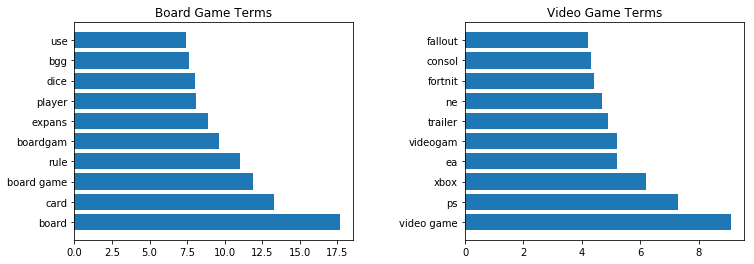

In [141]:
plt.subplots(figsize=(12, 4))
plt.subplot(121)
plt.barh(bg_terms, bg_scores)
plt.title('Board Game Terms')
plt.subplot(122)
plt.barh(vg_terms, vg_scores)
plt.title('Video Game Terms')
plt.subplots_adjust(wspace=.4);

## Executive Summary

We may often hear of the term gamer, but what does that mean? The goal of this project was to better understand the board gaming and video gaming communities by determining the differences in their word choice. We were looking for differences in three categories: words relating directly to the product, words representing the interaction with the product, and words related to the interaction between people. We used a logistic regression which was 98% accurate on the testing data. Based on the model, the most important terms were usually related to the product itself (board game, xbox, etc.). Some of the most important terms were in how people actually interacted with the product (trailer, rules, expansions, etc.). None of the most important terms related to how people interacted with each other. In the future, we would like to pursue analyzing which words are the best predictors of scores in corresponding subredddits. This should give us a better sense of how people interact with each other.